# Packages, import and preparation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, make_scorer
from ydata_profiling import ProfileReport
import matplotlib        as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Loading data

In [3]:
df15 = pd.read_csv('../processed_data/tab15')
df16 = pd.read_csv('../processed_data/tab16')
df17 = pd.read_csv('../processed_data/tab17')
df18 = pd.read_csv('../processed_data/tab18')
df19 = pd.read_csv('../processed_data/tab19')
df20 = pd.read_csv('../processed_data/tab20')
df21 = pd.read_csv('../processed_data/tab21')
frames = [df15, df16, df17, df18, df19, df20, df21]
df = pd.concat(frames)
df.drop(['KLUB'], axis=1, inplace=True)

# First look at the data

In [10]:
df.head()

,played,points,goals_for,goals_against,foreign_minutes,foreign_goals,young_minutes,young_goals,season
0,37,73,70,32,14846,51,2324,2,2015/2016
1,37,69,60,45,20666,40,3270,1,2015/2016
2,37,60,55,42,13202,9,5995,13,2015/2016
3,37,58,66,50,12329,36,5326,7,2015/2016
4,37,51,53,44,13296,19,5992,5,2015/2016


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 17
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   played           114 non-null    int64 
 1   points           114 non-null    int64 
 2   goals_for        114 non-null    int64 
 3   goals_against    114 non-null    int64 
 4   foreign_minutes  114 non-null    int64 
 5   foreign_goals    114 non-null    int64 
 6   young_minutes    114 non-null    int64 
 7   young_goals      114 non-null    int64 
 8   season           114 non-null    object
dtypes: int64(8), object(1)
memory usage: 8.9+ KB


In [12]:
df.groupby('season').median()

,played,points,goals_for,goals_against,foreign_minutes,foreign_goals,young_minutes,young_goals
season,,,,,,,,
2015/2016,37.0,48.0,44.0,46.5,12765.5,15.0,3702.5,3.5
2016/2017,37.0,46.5,49.0,54.0,12894.5,18.5,5128.5,8.0
2017/2018,37.0,50.0,49.5,50.0,18306.5,26.0,1173.0,1.0
2018/2019,37.0,50.5,49.5,51.5,16298.5,31.5,2741.5,2.0
2019/2020,37.0,53.0,48.0,49.0,18275.0,25.0,5298.0,4.5
2020/2021,30.0,39.0,37.5,35.0,13658.5,18.5,3833.5,2.5
2021/2022,34.0,44.5,42.5,49.0,15354.5,20.5,4080.0,4.0


In [13]:
df.groupby('season').std().drop(['played'], axis=1).round(2)

,points,goals_for,goals_against,foreign_minutes,foreign_goals,young_minutes,young_goals
season,,,,,,,
2015/2016,10.81,10.65,8.02,4201.37,13.55,2489.86,6.22
2016/2017,12.68,8.92,11.28,5226.91,14.69,3120.85,6.13
2017/2018,11.00,7.84,8.58,5097.70,10.23,2325.39,2.45
2018/2019,11.38,6.66,11.63,5531.65,9.48,2011.74,2.56
2019/2020,11.11,11.62,9.75,5027.71,10.40,1933.05,6.98
2020/2021,10.45,5.55,9.86,4350.18,10.03,1424.45,2.56
2021/2022,13.15,10.31,10.66,5489.81,11.27,1278.29,3.07


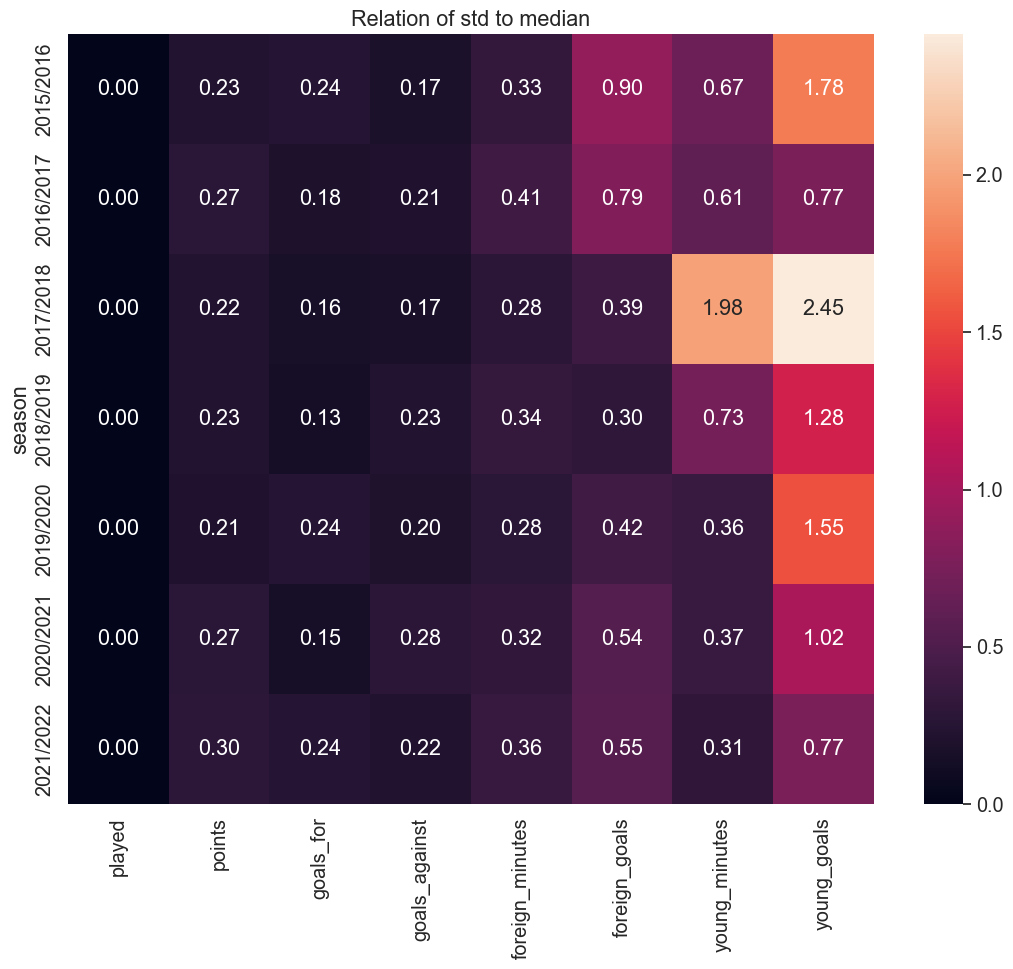

In [14]:
plt.figure(figsize=(13, 10))
std_to_med = df.groupby('season').std() / df.groupby('season').median()
plt.title('Relation of std to median')
sns.heatmap(std_to_med, annot=True, fmt=".2f")
sns.set(font_scale=5)

Text(0.5, 1.0, 'Inequalities in different seasons')

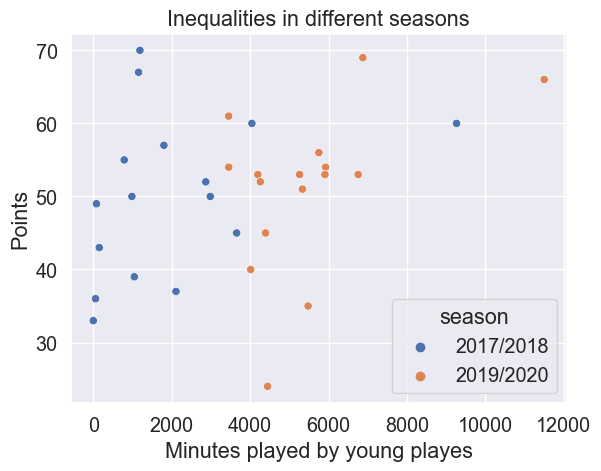

In [16]:
season_condition = df['season'] == '2017/2018'
second_cond = df['season'] == '2019/2020'
sns.scatterplot(data=df[season_condition | second_cond], x='young_minutes',y='points', hue='season')
sns.set(font_scale=1.3)
plt.xlabel('Minutes played by young playes')
plt.ylabel('Points')
plt.title('Inequalities in different seasons')

# Preprocessing

In [4]:
def metric_per_played(metric: str):
    df[f'{metric}'] = df[metric] / df['played']
def metric_goals_scored(metric: str):
    df[f'{metric}'] = df[metric] / df['goals_for']
def metric_season_standard(metric: str):
    df[f'{metric}'] = df.groupby('season')[metric].transform(lambda x: (x-x.median()) / x.mad())
for met in ['young_goals', 'foreign_goals']:
    metric_goals_scored(met)
for met in [column for column in df.columns if column!='played' and column != 'season']:
    metric_per_played(met)
for met in ['young_minutes', 'young_goals', 'foreign_minutes', 'foreign_goals']:
    metric_season_standard(met)
df.drop(['played'], axis=1, inplace=True)

# Analyzing processed data

In [18]:
df.groupby('season').median().round(2)

,points,goals_for,goals_against,foreign_minutes,foreign_goals,young_minutes,young_goals
season,,,,,,,
2015/2016,1.30,1.19,1.26,-0.0,-0.0,0.0,0.0
2016/2017,1.26,1.32,1.46,0.0,0.0,0.0,0.0
2017/2018,1.35,1.34,1.35,-0.0,0.0,0.0,0.0
2018/2019,1.36,1.34,1.39,0.0,0.0,0.0,-0.0
2019/2020,1.43,1.30,1.32,0.0,0.0,0.0,0.0
2020/2021,1.30,1.25,1.17,0.0,0.0,0.0,-0.0
2021/2022,1.31,1.25,1.44,-0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Inequalities removed')

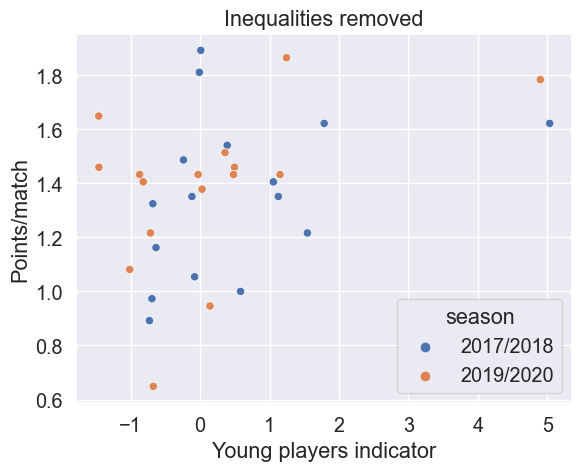

In [19]:
season_condition = df['season'] == '2017/2018'
second_cond = df['season'] == '2019/2020'
sns.scatterplot(data=df[season_condition | second_cond], x='young_minutes',y='points', hue='season')
sns.set(font_scale=1.3)
plt.xlabel('Young players indicator')
plt.ylabel('Points/match')
plt.title('Inequalities removed')

<Axes: >

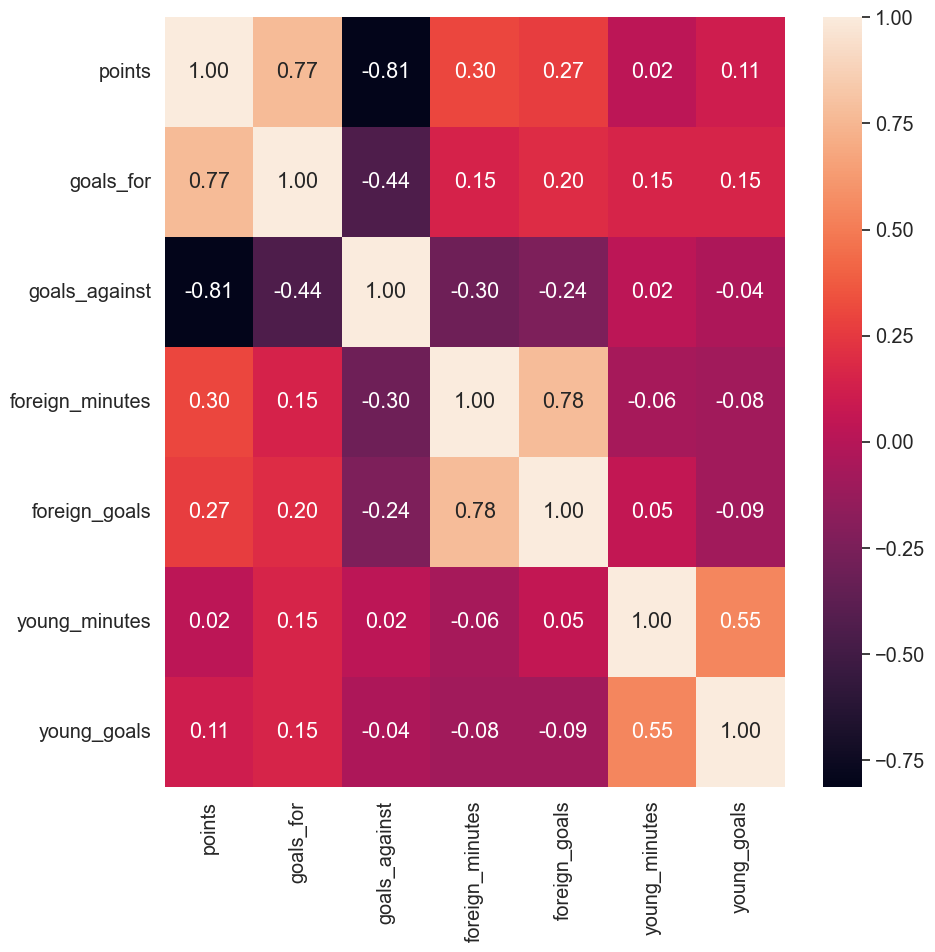

In [20]:
corrs = df.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(10, 10))
sns.heatmap(corrs, annot=True, fmt=".2f")

In [21]:
profile = ProfileReport()
profile.config.interactions.targets = ['points', 'foreign_minutes', 'young_minutes']
profile.df = df
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

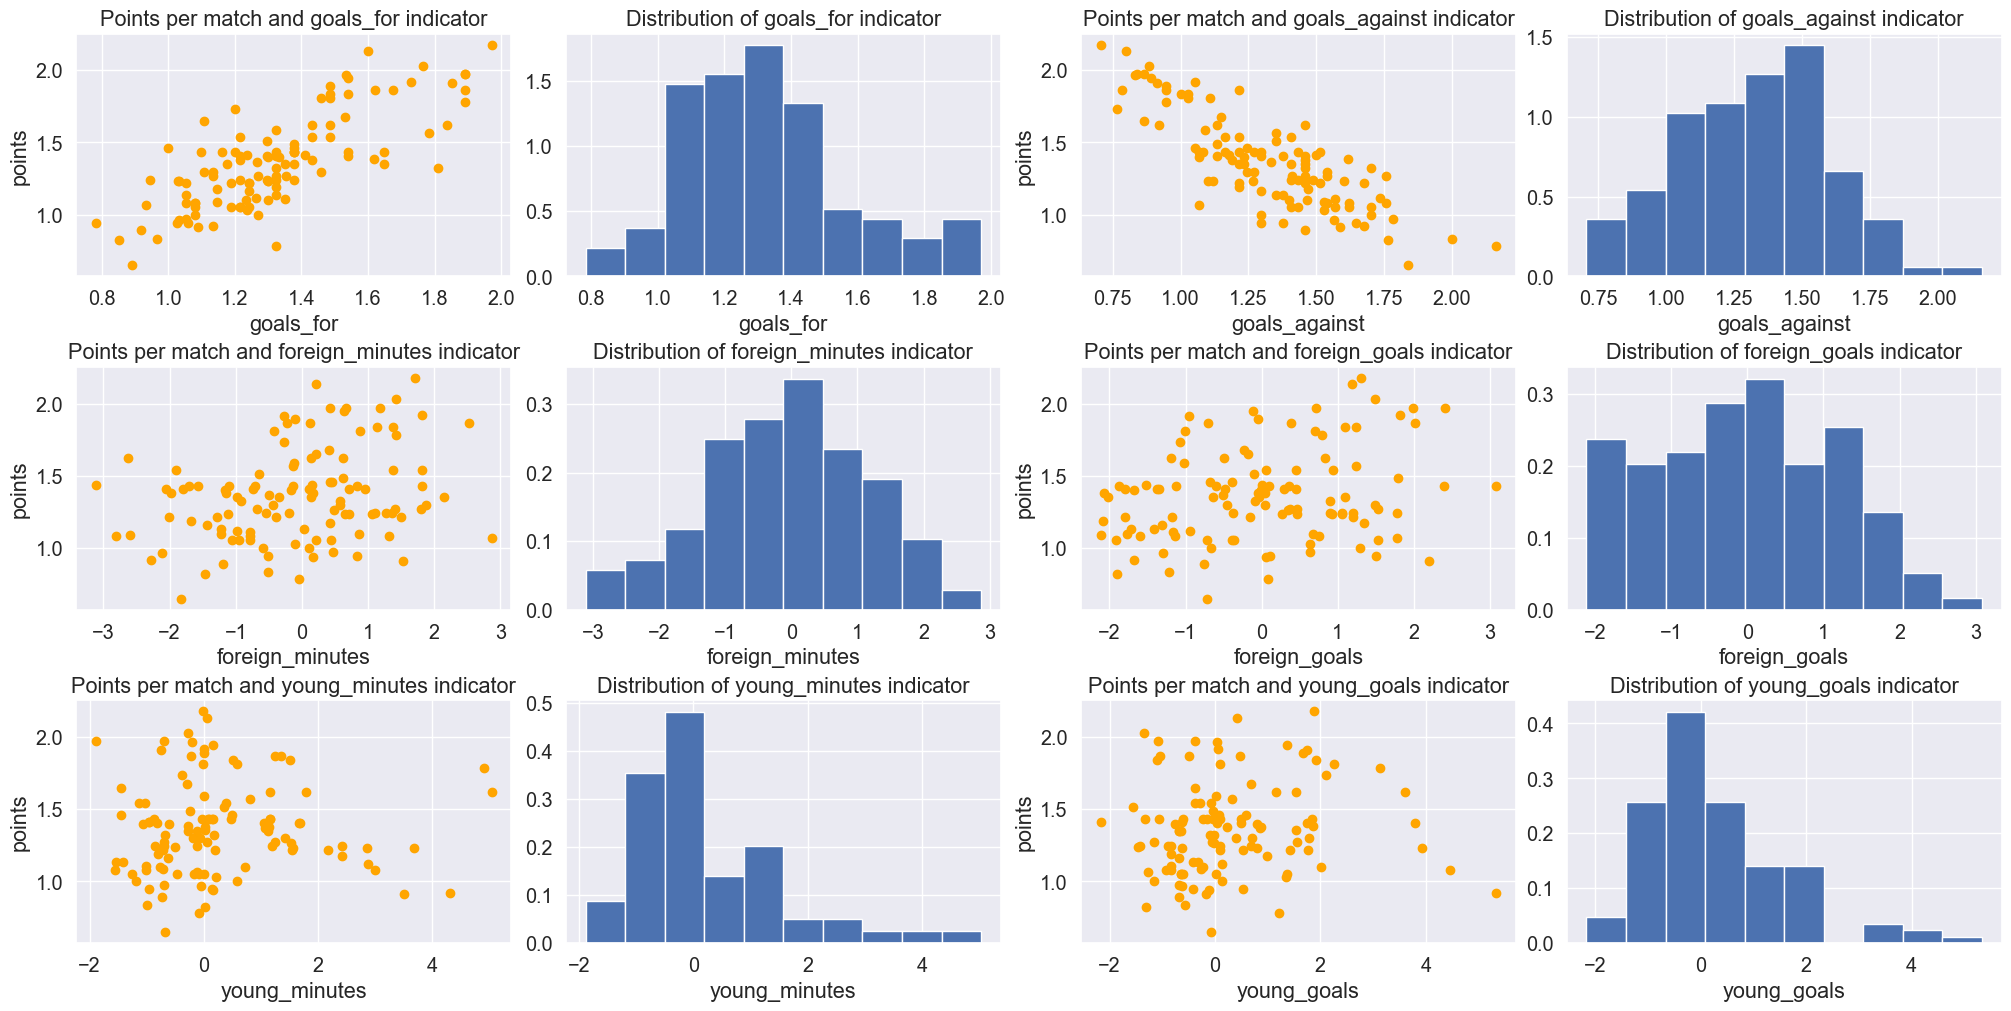

In [22]:
def plot_points_dependency(metric, ax):
    ax.scatter(x=df[metric], y=df['points'], color='orange')
    ax.set_title(f"Points per match and {metric} indicator")
    ax.set_xlabel(metric)
    ax.set_ylabel('points')


def plot_metric_distribution(metric, ax):
    ax.set_title(f"Distribution of {metric} indicator")
    ax.set_xlabel(metric)
    ax.hist(df[metric], density=True)

metrics_to_plot = df.drop(['points', 'season'],axis=1).columns
n_rows = (len(metrics_to_plot) + 1) // 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), layout='constrained')

for i in range(n_rows):
    for j in range(2):
        index = 2 * i + j
        if index < len(metrics_to_plot):
            metric_name = metrics_to_plot[2 * i + j]
            plot_points_dependency(metric_name, ax=axes[i, 2 * j])
            plot_metric_distribution(metric_name, ax=axes[i, 2 * j + 1])

# Searching for and implementing models

In [58]:
df['points'].mad()

0.24994639416995615

In [5]:
def find_best_parameters(model, parameters, X, y, cv=10, n_jobs=-1):
    grid_object = GridSearchCV(model, parameters, scoring=make_scorer(mean_absolute_error, greater_is_better=False), cv=cv, verbose=True,n_jobs=n_jobs)
    grid_object = grid_object.fit(X, y)
    return grid_object.best_params_

In [56]:
X = df.drop(['points','season','goals_for','goals_against'], axis=1)
y = df['points']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=13 ,shuffle=True)
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
svm_easy = SVR(kernel='linear')

parameters = {'kernel': ['linear','poly','rbf'],
              'C': [1.0,2.0, 5.0,10.0,15.0],
              'gamma': [0.001,0.005,0.01,0.05,0.1,1]
              }

svm_params = find_best_parameters(svm_easy, parameters, X_train, y_train)
print(svm_params)
svm_hard = SVR(**svm_params)
svm_hard.fit(X_train, y_train)
y_pred = svm_hard.predict(X_test)
mean_absolute_error(y_true=y_test, y_pred=y_pred)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
{'C': 2.0, 'gamma': 0.05, 'kernel': 'rbf'}


0.2940726286190242

In [59]:
X = df.drop(['points', 'season', 'foreign_minutes', 'foreign_goals','young_minutes','young_goals'], axis=1)
y = df['points']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=13, shuffle=True)
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
svm_easy = SVR(kernel='linear')

parameters = {'kernel': ['linear', 'poly', 'rbf'],
              'C': [1.0, 2.0, 5.0, 10.0, 15.0],
              'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 1]
              }

svm_params = find_best_parameters(svm_easy, parameters, X_train, y_train)
print(svm_params)
svm_easy = SVR(**svm_params)
svm_easy.fit(X_train, y_train)
y_pred = svm_easy.predict(X_test)
mean_absolute_error(y_true=y_test, y_pred=y_pred)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'}


0.10164191101487306

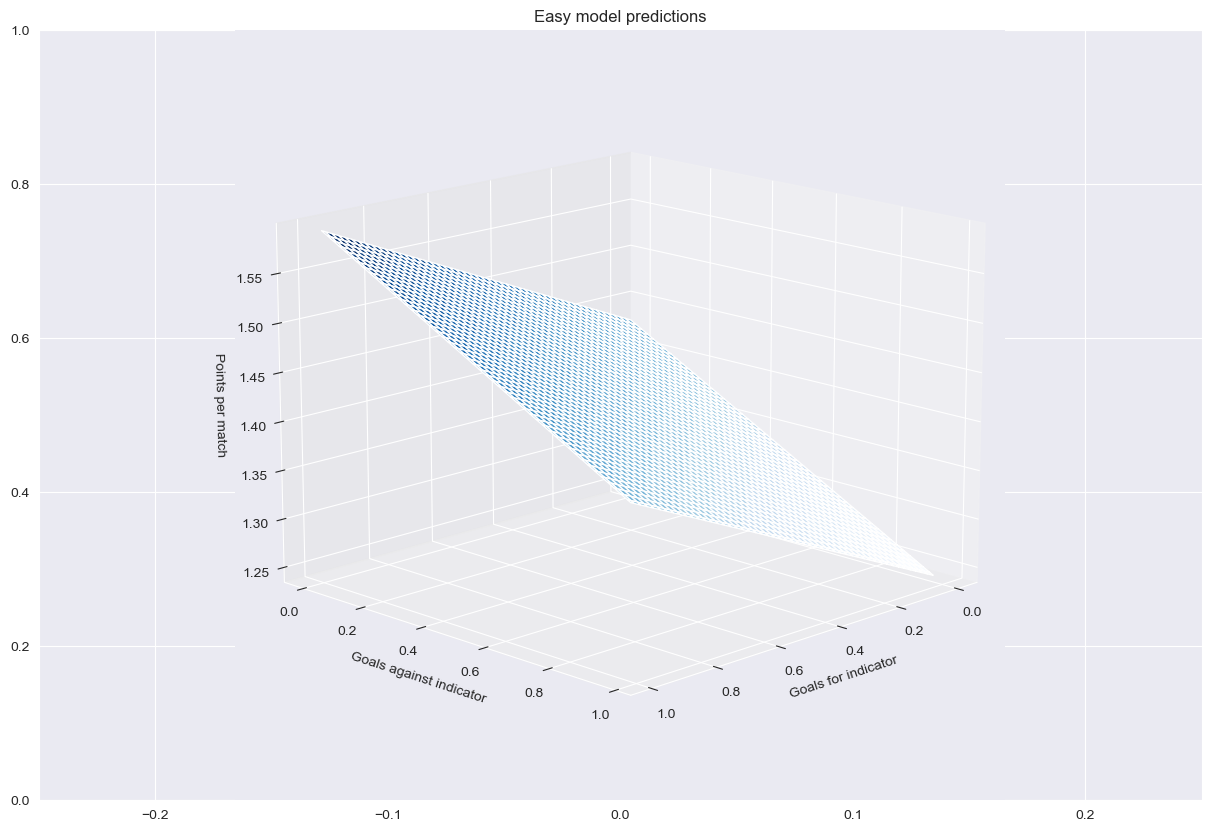

In [60]:
X = np.random.rand(100, 2)

fig = plt.figure(figsize=(15,10))
plt.margins(tight=False, x=2)
ax = fig.add_subplot(111, projection='3d')

X1 = X[:, 0]
X2 = X[:, 1]

X1_grid, X2_grid = np.meshgrid(np.linspace(X1.min(), X1.max(), 100),
                               np.linspace(X2.min(), X2.max(), 100))

y_pred = svm_easy.predict(np.c_[X1_grid.ravel(), X2_grid.ravel()])
y_pred = y_pred.reshape(X1_grid.shape)

cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[0:,:-1])
ax.plot_surface(X1_grid, X2_grid, y_pred, cmap=cmap,)


ax.set_xlabel('Goals for indicator')
ax.set_ylabel('Goals against indicator')
ax.set_zlabel('Points per match')
ax.set_title('Easy model predictions')
ax.view_init(elev=15, azim=45)

plt.show()

# Extras

In [10]:
data22 = pd.read_csv('../processed_data/tab22')
dataMan = data22.copy()
def metric_per_played(metric: str):
    dataMan[f'{metric}'] = dataMan[metric] / dataMan['played']
def metric_goals_scored(metric: str):
    dataMan[f'{metric}'] = dataMan[metric] / dataMan['goals_for']
def metric_season_standard(metric: str):
    dataMan[f'{metric}'] = dataMan.groupby('season')[metric].transform(lambda x: (x-x.median()) / x.mad())
for met in ['young_goals', 'foreign_goals']:
    metric_goals_scored(met)
for met in [column for column in df.columns if column!='played' and column != 'season']:
    metric_per_played(met)
for met in ['young_minutes', 'young_goals', 'foreign_minutes', 'foreign_goals']:
    metric_season_standard(met)
played = dataMan['played'].mean()
dataMan.drop(['played'], axis=1, inplace=True)
data22['old_index'] = data22.index+1

In [23]:
X = dataMan[['foreign_minutes', 'foreign_goals', 'young_minutes', 'young_goals']]
y_true = dataMan['points']
y_pred = svm_hard.predict(X)
mean_absolute_error(y_true=y_true, y_pred=y_pred)
data22['predicted_points'] = (y_pred*played).round().astype(int)
hard_table = data22[['old_index', 'KLUB', 'points', 'predicted_points']].sort_values('predicted_points', ascending=False).reset_index(drop=True).reset_index(names='new_index')
hard_table['new_index'] = hard_table['new_index'] + 1
hard_table['index_change'] = (hard_table['old_index'] - hard_table['new_index'])
hard_table['points_change'] = (hard_table['predicted_points'] - hard_table['points'])
print('sum of index difference:', hard_table['index_change'].abs().sum())
print('sum of points difference:', hard_table['points_change'].abs().sum())
col = hard_table['old_index'] - 1
hard_table.set_index(col, inplace=True)
for metric in ['foreign_minutes', 'foreign_goals', 'young_minutes', 'young_goals']:
    hard_table[metric] = data22[metric]
hard_table.reset_index(drop=True, inplace=True)
hard_table[['new_index', 'index_change' , 'KLUB', 'predicted_points', 'points_change','foreign_minutes', 'foreign_goals', 'young_minutes', 'young_goals']]

sum of index difference: 84
sum of points difference: 162


,new_index,index_change,KLUB,predicted_points,points_change,foreign_minutes,foreign_goals,young_minutes,young_goals
0,1,4,Piast,67,17,20654,31,3191,7
1,2,8,Cracovia,54,11,17250,26,3255,5
2,3,-1,Legia,53,-10,19521,21,4506,12
3,4,4,Radomiak,53,9,21886,27,3188,3
4,5,-4,Raków,53,-21,22075,20,4149,11
5,6,-3,Lech,51,-7,21792,37,3786,5
6,7,5,Jagiellonia,49,8,24230,40,1042,0
7,8,6,Korona,48,10,18001,29,4004,3
8,9,7,Wisła,45,8,14908,16,3050,4
9,10,7,Lechia,45,15,9668,16,3160,3


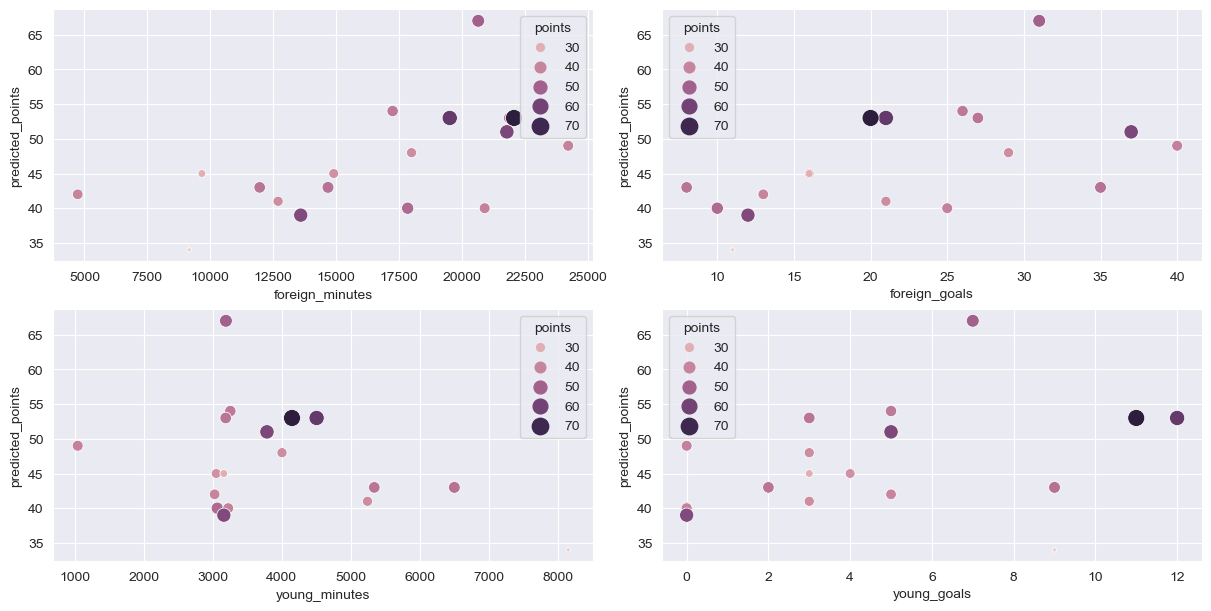

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), layout='constrained')

def plot_to_predicted(metric, ax):
    sns.scatterplot(
    x=metric,
    y='predicted_points',
    data=hard_table,
    hue='points',
    size='points',
    sizes=(10,150),
    legend='brief',
    ax=ax)

metrics_to_plot = ['foreign_minutes', 'foreign_goals', 'young_minutes', 'young_goals']

for i in range(2):
    for j in range(2):
        index = 2 * i + j
        if index < len(metrics_to_plot):
            metric_name = metrics_to_plot[2 * i + j]
            plot_to_predicted(metric_name, ax=axes[i, j])

In [62]:
X = dataMan[['goals_for', 'goals_against']]
y_true = dataMan['points']
y_pred = svm_easy.predict(X)
mean_absolute_error(y_true=y_true, y_pred=y_pred)
data22['predicted_points'] = (y_pred*played).round().astype(int)
easy_table = data22[['old_index', 'KLUB', 'points', 'predicted_points']].sort_values('predicted_points', ascending=False).reset_index(drop=True).reset_index(names='new_index')
easy_table['new_index'] = easy_table['new_index'] + 1
easy_table['index_change'] = (easy_table['old_index'] - easy_table['new_index'])
easy_table['points_change'] = (easy_table['predicted_points'] - easy_table['points'])
print('sum of index difference:', easy_table['index_change'].abs().sum())
print('sum of points difference:', easy_table['points_change'].abs().sum())
col = easy_table['old_index'] - 1
easy_table.set_index(col, inplace=True)
for metric in ['goals_for', 'goals_against',]:
    easy_table[metric] = data22[metric]
easy_table.reset_index(drop=True, inplace=True)
easy_table[['new_index', 'index_change' , 'KLUB', 'predicted_points', 'points_change','goals_for', 'goals_against']]

sum of index difference: 30
sum of points difference: 131


,new_index,index_change,KLUB,predicted_points,points_change,goals_for,goals_against
0,1,0,Raków,53,-21,62,23
1,2,1,Lech,50,-8,49,29
2,3,-1,Legia,49,-14,54,36
3,4,3,Warta,47,2,37,34
4,5,5,Cracovia,47,4,38,35
5,6,-1,Piast,47,-3,37,31
6,7,-3,Pogoń,47,-10,53,46
7,8,-2,Górnik,46,-1,45,43
8,9,-1,Radomiak,46,2,34,37
9,10,2,Jagiellonia,46,5,48,47


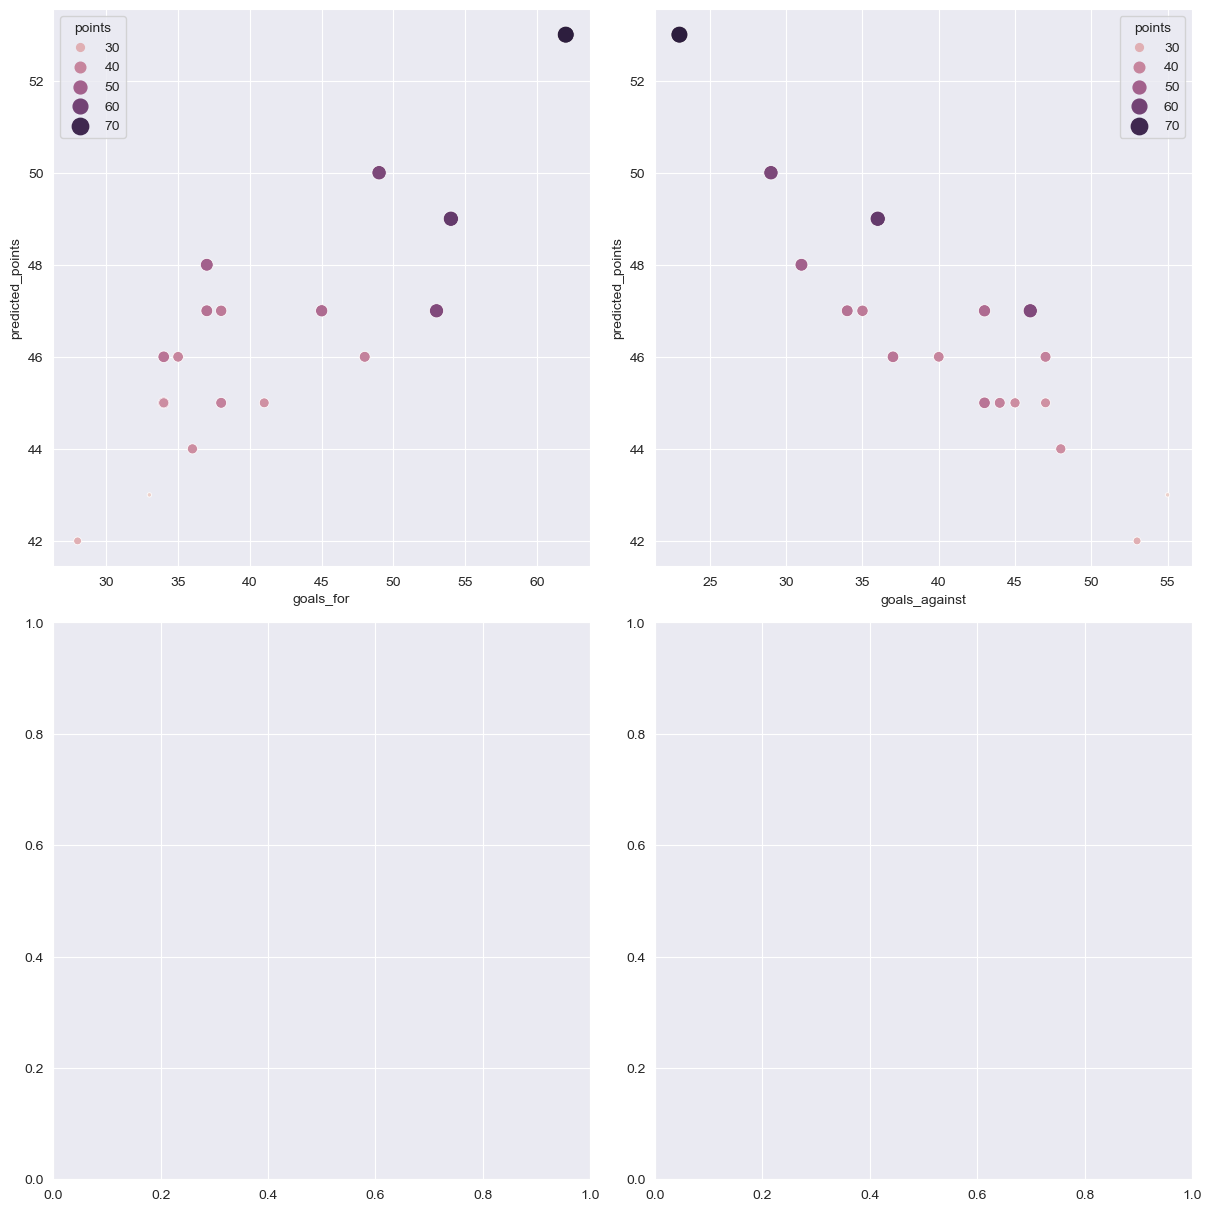

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), layout='constrained')

def plot_to_predicted(metric, ax):
    sns.scatterplot(
    x=metric,
    y='predicted_points',
    data=easy_table,
    hue='points',
    size='points',
    sizes=(10,150),
    legend='brief',
    ax=ax)

metrics_to_plot = ['goals_for', 'goals_against']

for i in range(1):
    for j in range(2):
        index = 2 * i + j
        if index < len(metrics_to_plot):
            metric_name = metrics_to_plot[2 * i + j]
            plot_to_predicted(metric_name, ax=axes[i, j])